In [1]:
import rasterio as rio
from rasterio.plot import show
from shapely.geometry import Polygon, mapping
from rasterio.mask import mask
from rasterio import features
import geopandas as gpd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import gdal
import timeit


# Loading Vector Files
- Files saved locally in Nero, need to find a way to connect from server using PostGIS

In [2]:
#loading Topo Building shapefile
vect= gpd.read_file('/media/DATADRIVE/permability/cleanup/CITYPRJ_TOPO_BUILDING.shp') 

#loading Road Poly shapefile
road = gpd.read_file('/media/DATADRIVE/permability/cleanup/Road_Poly.shp')


# Function to rasterize files

In [103]:
def burn_raster(raster_file, output_location):
    src = rio.open(raster_file) 
    #has to be set to 1, bands are indexed from 1
    src_read=src.read(1) 
    # copy and update the metadata from the input raster for the output
    meta = src.meta.copy()
    vect['TYPECODE']=1
    #creating the building polygons into num array variable
    bldg = vect.iloc[list(vect.sindex.intersection(src.bounds))]
    shapes = ((geom,value) for geom, value in zip(bldg.geometry, bldg.TYPECODE))
    road['TYPECODE']=1
    #creating the road polygons into num array variable
    roads = road.iloc[list(road.sindex.intersection(src.bounds))]
    shapes2 = ((geom,value) for geom, value in zip(roads.geometry, roads.TYPECODE))
    with rio.open(output_location, 'w', **meta) as out: 
        # **meta argument takes all the meta data information and applies it to the new output raster

        #rasterizing building polygon to raster file
        try:
            burned = features.rasterize(shapes=shapes, 
                                    fill=0, #values for all pixels that doesn't touch with a polygon
                                    out_shape=src.shape, #inherit the shape of reading raster file
                                    transform=src.transform, #same transform as reading raster file
                                    all_touched=True).astype(np.uint8)
        except:
            burned = np.zeros_like(src.shape)

        #rasterizing road polygon to raster file
        try:
            burned2 = features.rasterize(shapes=shapes2, 
                                     fill=0, #values for all pixels that doesn't touch with a polygon
                                     out_shape=src.shape, #inherit the shape of reading raster file
                                     transform=src.transform, #same transform as reading raster file
                                     all_touched=True).astype(np.uint8)
        except:
            burned2 = np.zeros_like(src.shape)
        #print("Roads ",burned2)
        #print("Buldings ", burned)
        src_read[src_read >=4] = 0 #any value greater than 2 is assigned 0 -permeable
        src_read[src_read <4] = 1#any value with 2 are assigned 1 - impermeable
        #combining the rasterized layers and reading raster files together in one array
        x2 = np.stack((burned2,burned)).sum(axis=0).astype(np.uint8) 
        x2[x2 > 1] = 1 #any value greater than 2 is assigned 1 -impermeable
        #x2[(x2 < 1) | (np.isnan(x2))] = 0 #any value with 2 are assigned 0 - permeable
        x2 = np.stack((x2,src_read)).sum(axis=0).astype(np.uint8) 
        print("Results ", x2)

        out.write_band(1,x2)

# Excuting the rasterization (burning of raster files)

In [104]:
#reading directory folder location
image_dir= '/media/DATADRIVE/permability/out_tifs/'

#output directory folder location
out_dir = '/media/DATADRIVE/permability/cleaned_tiffs/'

for image in os.listdir(image_dir):
    #iterating through only the tif files
    if image.endswith('.tif') and image.startswith('JA'): 
        x =image[:-4]+'_roadbuilding.tif'
        if os.path.isfile(out_dir+x):
            burn_raster(image_dir+image, out_dir+x)
            print (image, 'completed at:', datetime.datetime.now().isoformat(' ', 'seconds'))
    else:
        pass

print ('Processing Complete', datetime.datetime.now().isoformat(' ', 'seconds')) 


Results  [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
JAU1_9classified.tif completed at: 2019-01-19 15:34:25
Results  [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]]
JAQ2_9classified.tif completed at: 2019-01-19 15:34:27
Results  [[2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 ...
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]]
JAQ3_9classified.tif completed at: 2019-01-19 15:34:28
Results  [[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
JAQ4_9classified.tif completed at: 2019-01-19 15:34:30
Results  [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
JAR1_9classified.tif completed at: 2019-01-19 15:34:32
Results  [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 .

JAP1_9classified.tif completed at: 2019-01-19 15:35:45
Results  [[2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
JAP2_9classified.tif completed at: 2019-01-19 15:35:47
Results  [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
JAP3_9classified.tif completed at: 2019-01-19 15:35:49
Results  [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
JAP4_9classified.tif completed at: 2019-01-19 15:35:51
Results  [[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
JAA1_9classified.tif completed at: 2019-01-19 15:35:53
Results  [[2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
JAA2_9classified.tif completed at: 2019-01-19 15:35:54
Results  [[1 1 1 ... 1 1 

JAW4_9classified.tif completed at: 2019-01-19 15:37:02
Results  [[2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
JAX1_9classified.tif completed at: 2019-01-19 15:37:04
Results  [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
JAX2_9classified.tif completed at: 2019-01-19 15:37:06
Results  [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
JAX3_9classified.tif completed at: 2019-01-19 15:37:08
Results  [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
JAX4_9classified.tif completed at: 2019-01-19 15:37:10
Results  [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
JAY1_9classified.tif completed at: 2019-01-19 15:37:12
Results  [[1 1 1 ... 1 1 

In [91]:
if shapes2:
    print('go')


go


Roads  [[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Buldings  [[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
Results  [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


# For Visuals to compare tif files

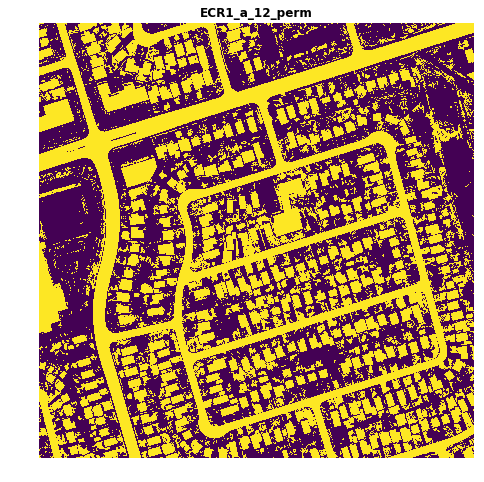

In [83]:
fig, ax = plt.subplots(figsize=(8,8))
show(x2, 
        title="ECR1_a_12_perm", 
        ax=ax)
ax.set_axis_off()


In [74]:
road

,OBJECTID,TYPECODE,TYPE,SUBTYPECOD,SUBTYPE,ELEVATION,OWNERSHIP,LAST_GEOM_,LAST_ATTRI,SHAPE_Leng,SHAPE_Area,geometry
0,1,1,Roadway,1001,Edge of Road,0.0,None,None,None,1998.372062,12243.243091,POLYGON Z ((296006.5530000003 4833841.81399999...
1,2,1,Roadway,1001,Edge of Road,0.0,None,None,None,1433.819022,2727.593439,POLYGON Z ((297494.9753 4834240.0428 73.717099...
2,3,1,Roadway,1001,Edge of Road,0.0,None,None,None,126.919974,410.468241,POLYGON Z ((298353.6322999997 4834427.34 146.4...
3,4,1,Roadway,1001,Edge of Road,0.0,None,None,None,5791.515469,19230.922799,POLYGON Z ((297208.7298999997 4834443.4004 150...
4,5,1,Roadway,1001,Edge of Road,0.0,None,None,None,222.893686,495.856692,POLYGON Z ((297267.4119999995 4834472.7612 150...
5,6,1,Roadway,1001,Edge of Road,0.0,None,None,None,29.903936,32.323292,POLYGON Z ((297515.1973000001 4834467.63560000...
6,7,1,Roadway,1001,Edge of Road,0.0,None,None,None,608.657282,1901.590464,POLYGON Z ((298241.4341000002 4834546.75809999...
7,8,1,Roadway,1001,Edge of Road,0.0,None,None,None,372.170571,999.500784,POLYGON Z ((297231.5673000002 4834583.40630000...
8,9,1,Roadway,1001,Edge of Road,0.0,None,None,None,3560.314128,23670.293367,POLYGON Z ((296612.3006999996 4834570.33410000...
9,10,1,Roadway,1001,Edge of Road,0.0,None,None,None,320.894192,298.791337,POLYGON Z ((297378.6606999999 4834649.1195 152...
